<a href="https://colab.research.google.com/github/kreee00/intro-data-science/blob/main/Copy_of_DS_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RECOMMENDER SYSTEM**

---

GROUP ASSIGNMENT - DATA SCIENCE - TEB2043

| No | Name | ID | UTP Email |
| --- | --- | --- | --- |
| 1 | LU HOU YANG | 22012138 | lu_22012138@utp.edu.my |
| 2 | MOHAMAD AKRAM BIN MOHD FAISAL | 22006626 | mohamad_22006626@utp.edu.my |
| 3 | SHARVIN A/L KANESAN | 22006930 | sharvin_22006930@utp.edu.my |
| 4 | MYRA AMANI AMRAN | 22006851 | myra_22006851@utp.edu.my |



## **Install Packages**

In [ ]:
install.packages("readr")
install.packages("googledrive")
install.packages("ggplot2")
install.packages("dplyr")
install.packages("tidyverse")
install.packages("recommenderlab")
install.packages("tidyr")
install.packages("xgboost")
install.packages("Matrix")
install.packages("caret")
install.packages("data.table")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("readr"):
“installation of package ‘readr’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("googledrive"):
“installation of package ‘googledrive’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("ggplot2"):
“installation of package ‘ggplot2’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘float’, ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’, ‘matrixStats’


Warning message in install.packages("recomm

In [ ]:
library(readr)
library(googledrive)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(recommenderlab)
library(tidyr)
library(xgboost)
library(Matrix)
library(caret)
library(data.table)


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




## **Download Dataset**

Answer `1`: Yes when prompted. Click the link and give relevant access to tidyverse. Copy the token and wait for the files to be downloaded.

In [ ]:
file_ids <- c(
  "1T2V_NrGkhNmRupyN7pu6Vwta-x0Emcef", # links
  "1zOXfYxhJayYmNj034m5aEWREoHECAUOs", # movies
  "10io-cNsY3uYgsuoHHl59cfl5_Xzv4ret", # ratings
  "1zsPDonH4-rHY40_jkjr_g-SGQzfb0-Jm", # tags
  "1GBRDWnvYuIaiVb--S_mkAYI6N25g8nqT", # checksums.txt
  "1A16Ax9pWz4UvbFOCcQDSD1vD0Zil0yxG"  # README.txt
)

file_names <- c(
  "links.csv",
  "movies.csv",
  "ratings.csv",
  "tags.csv",
  "checksums.txt",
  "README.txt"
)

for (i in 1:length(file_ids)) {
  drive_download(
    as_id(file_ids[i]),
    path = file_names[i],
    overwrite = TRUE
  )
}


The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: luhouyang@gmail.com


Selection: 2


Auto-refreshing stale OAuth token.

File downloaded:

• links.csv <id: 1T2V_NrGkhNmRupyN7pu6Vwta-x0Emcef>

Saved locally as:

• links.csv

File downloaded:

• movies.csv <id: 1zOXfYxhJayYmNj034m5aEWREoHECAUOs>

Saved locally as:

• movies.csv



## **Preprocessing**

### Dataset Profile

In [ ]:
ratings <- read_csv("ratings.csv")
movies <- read_csv("movies.csv")
links <- read_csv("links.csv")
tags <- read_csv("tags.csv")

In [ ]:
head(ratings)
head(movies)
head(links)
head(tags)

In [ ]:
spec(ratings)
spec(movies)
spec(links)
spec(tags)

### Preprocessing

Filter for duplicates

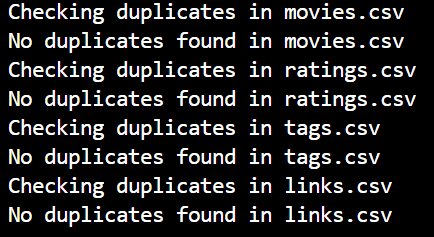

Code

```python
import os
import polars as pl


def find_duplicates(file_path):
    df = pl.read_csv(file_path)

    duplicates = df.filter(df.is_duplicated())
    return duplicates


def fix_duplicates(file_path, keep='first'):
    df = pl.read_csv(file_path)

    df_cleaned = df.unique(keep=keep)
    df_cleaned.write_csv(file_path)


def main():
    base_dir = r"D:\storage\ml-32m\ml-32m"
    files = ['movies.csv', 'ratings.csv', 'tags.csv', 'links.csv']

    for file_name in files:
        file_path = os.path.join(base_dir, file_name)

        print(f"Checking duplicates in {file_name}")
        duplicates = find_duplicates(file_path)
        if duplicates is not None and not duplicates.is_empty():
            print(f"Duplicates found in {file_name}:")
            print(duplicates)
            fix_duplicates(file_path)
        else:
            print(f"No duplicates found in {file_name}")


if __name__ == "__main__":
    main()
```

In [ ]:
dataframes <- list(ratings = ratings, movies = movies, links = links, tags = tags)

In [ ]:
summarize_dataframes <- function(dataframes) {
  for (name in names(dataframes)) {
    cat("\nSummary for:", name, "\n")
    print(summary(dataframes[[name]]))
    cat("\n------------------------------\n")
  }
}

In [ ]:
summarize_dataframes(dataframes)

Check for missing data:

- Missing rating will be replaced with mean

- Other rows for missing categorical or unique values will be dropped if the movieId or userId is missing

In [ ]:
clean_missing_data <- function(df, df_name) {
  cat("\nHandling missing data for:", df_name, "\n")

  initial_rows <- nrow(df)

  if ("rating" %in% colnames(df)) {
    na_count <- sum(is.na(df$rating))
    mean_rating <- mean(df$rating, na.rm = TRUE)
    df$rating[is.na(df$rating)] <- mean_rating
    cat("Replaced", na_count, "NA values in 'rating' with mean:", mean_rating, "\n")
  }

  if ("movieId" %in% colnames(df) & "userId" %in% colnames(df)) {
    rows_with_na <- sum(is.na(df$movieId) | is.na(df$userId))
    df <- df[!is.na(df$movieId) & !is.na(df$userId), ]
    cat("Removed", rows_with_na, "rows due to missing 'movieId' or 'userId'\n")
  }

  removed_rows <- initial_rows - nrow(df)
  cat("Total rows removed:", removed_rows, "\n")

  return(df)
}

In [ ]:
for (name in names(dataframes)) {
  dataframes[[name]] <- clean_missing_data(dataframes[[name]], name)
}

Use Box Plots & Scatter Plots to visualize & identify outliers

In [ ]:
plot_rating_boxplot <- function(df) {
  if ("rating" %in% colnames(df)) {
    p <- ggplot(df, aes(x = "", y = rating)) +
      geom_boxplot(fill = "blue", alpha = 0.5) +
      labs(title = "Boxplot of Rating", y = "Rating") +
      theme_minimal()
    print(p)

    rm(p)
    gc()
  }
}


plot_imdbId_length <- function(df) {
  if ("imdbId" %in% colnames(df)) {
    df$imdb_length <- nchar(as.character(df$imdbId))

    p <- ggplot(df, aes(x = imdb_length)) +
      geom_histogram(fill = "green", bins = 10, alpha = 0.5) +
      labs(title = "Histogram of IMDb ID Length", x = "IMDb ID Length", y = "Count") +
      theme_minimal()
    print(p)

    rm(p)
    gc()
  }
}

check_genre_typos <- function(df) {
  valid_genres <- c("Action", "Adventure", "Animation", "Children's", "Comedy",
                    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                    "Thriller", "War", "Western", "(no genres listed)")

  if ("genres" %in% colnames(df)) {
    genre_list <- unique(unlist(strsplit(df$genres, "\\|")))
    typos <- setdiff(genre_list, valid_genres)

    if (length(typos) > 0) {
      cat("Possible typos in genres:\n", paste(typos, collapse = ", "), "\n")
    } else {
      cat("No typos found in genres.\n")
    }
  }
}

plot_tag_length <- function(df) {
  if ("tag" %in% colnames(df)) {
    df$tag_length <- nchar(as.character(df$tag))

    p <- ggplot(df, aes(x = tag_length)) +
      geom_histogram(fill = "red", bins = 20, alpha = 0.5) +
      labs(title = "Histogram of Tag Length", x = "Tag Length", y = "Count") +
      theme_minimal()
    print(p)

    rm(p)
    gc()
  }
}

In [ ]:
plot_rating_boxplot(dataframes[["ratings"]])

In [ ]:
plot_imdbId_length(dataframes[["links"]])

In [ ]:
check_genre_typos(dataframes[["movies"]])

In [ ]:
plot_tag_length(dataframes[["tags"]])

Fix `Children` genre typo to `Children's`

In [ ]:
check_and_fix_genres <- function(df) {
  valid_genres <- c("Action", "Adventure", "Animation", "Children's", "Comedy",
                    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                    "Thriller", "War", "Western", "(no genres listed)")

  if ("genres" %in% colnames(df)) {
    df$genres <- gsub("\\bChildren\\b", "Children's", df$genres)

    genre_list <- unique(unlist(strsplit(df$genres, "\\|")))
    typos <- setdiff(genre_list, valid_genres)

    if (length(typos) > 0) {
      cat("Possible typos in genres:\n", paste(typos, collapse = ", "), "\n")
    } else {
      cat("No typos found in genres.\n")
    }
  }

  return(df)
}

In [ ]:
movies <- check_and_fix_genres(movies)

### Transformation

Coding `genre` into dummy variables

In [ ]:
encode_genres <- function(df) {
  if ("genres" %in% colnames(df)) {
    df <- df %>%
      separate_rows(genres, sep = "\\|") %>%
      mutate(value = 1) %>%
      pivot_wider(names_from = genres, values_from = value, values_fill = list(value = 0))
  }
  return(df)
}

In [ ]:
movies <- encode_genres(movies)

head(movies)
summary(movies)

Merging dataset

In [ ]:
Sys.sleep(3)
rm(ratings, movies, links, tags, dataframes)
gc()

In [ ]:
# merged_df <- ratings %>%
#   inner_join(movies, by = "movieId") %>%
#   left_join(tags, by = c("userId", "movieId")) %>%
#   left_join(links, by = "movieId")

In [ ]:
# merged_df$tag[is.na(merged_df$tag)] <- ""

# if ("timestamp.y" %in% colnames(merged_df)) {
#   min_timestamp <- min(merged_df$timestamp.y, na.rm = TRUE)
#   merged_df$timestamp.y[is.na(merged_df$timestamp.y)] <- min_timestamp
# }

In [ ]:
# head(merged_df)
# summary(merged_df)

Utility function to get dataset

In [ ]:
get_separated_dataframes <- function() {
  rm(ratings, movies, links, tags, dataframes)
  gc()

  ratings <- read_csv("ratings.csv")
  movies <- read_csv("movies.csv")
  links <- read_csv("links.csv")
  tags <- read_csv("tags.csv")

  if ("timestamp" %in% colnames(ratings)) {
    ratings <- ratings %>% select(-timestamp)
  }

  if ("timestamp" %in% colnames(tags)) {
    tags <- tags %>% select(-timestamp)
  }

  movies <- check_and_fix_genres(movies)
  movies <- encode_genres(movies)

  dataframes <- list(ratings = ratings, movies = movies, links = links, tags = tags)

  for (name in names(dataframes)) {
    dataframes[[name]] <- clean_missing_data(dataframes[[name]], name)
  }

  rm(movies, ratings, tags, links)
  gc()

  return(dataframes)
}

In [ ]:
get_merged_dataframe <- function() {
  rm(ratings, movies, links, tags, merged_df)
  gc()

  ratings <- read_csv("ratings.csv")
  movies <- read_csv("movies.csv")
  # links <- read_csv("links.csv")
  tags <- read_csv("tags.csv")

  movies <- check_and_fix_genres(movies)
  movies <- encode_genres(movies)

  if ("timestamp" %in% colnames(ratings)) {
    ratings <- ratings %>% select(-timestamp)
  }

  if ("timestamp" %in% colnames(tags)) {
    tags <- tags %>% select(-timestamp)
  }

  merged_df <- ratings %>%
    inner_join(movies, by = "movieId") %>%
    left_join(tags, by = c("userId", "movieId"))

  rm(ratings, movies, links, tags)

  merged_df$tag[is.na(merged_df$tag)] <- ""

  gc()

  return(merged_df)
}

In [ ]:
# dataframes <- get_separated_dataframes()

In [ ]:
# merged_df <- get_merged_dataframe()

## **EDA**

Overview of dataframe

### Univariate

### Bivariate

## **Collaborative Filtering (User-based)**

In [ ]:
library(readr)
library(dplyr)
library(Matrix)
library(xgboost)
library(caret)
library(data.table)
library(recommenderlab)

# Function to clean missing data (using data.table for efficiency)
clean_missing_data <- function(dt, dt_name) {
  cat("\nHandling missing data for:", dt_name, "\n")
  initial_rows <- nrow(dt)

  if ("rating" %in% names(dt)) {
    na_count <- sum(is.na(dt$rating))
    mean_rating <- mean(dt$rating, na.rm = TRUE)
    dt[is.na(rating), rating := mean_rating]
    cat("Replaced", na_count, "NA values in 'rating' with mean:", mean_rating, "\n")
  }

  if ("movieId" %in% names(dt) & "userId" %in% names(dt)) {
    rows_with_na <- sum(is.na(dt$movieId) | is.na(dt$userId))
    dt <- dt[!is.na(movieId) & !is.na(userId)]
    cat("Removed", rows_with_na, "rows due to missing 'movieId' or 'userId'\n")
  }

  removed_rows <- initial_rows - nrow(dt)
  cat("Total rows removed:", removed_rows, "\n")
  return(dt)
}

# Function to check and fix genres
check_and_fix_genres <- function(dt) {
  valid_genres <- c("Action", "Adventure", "Animation", "Children's", "Comedy",
                    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir",
                    "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
                    "Thriller", "War", "Western", "(no genres listed)")

  if ("genres" %in% names(dt)) {
    dt[, genres := gsub("\\bChildren\\b", "Children's", genres)]
    genre_list <- unique(unlist(strsplit(dt$genres, "\\|")))
    typos <- setdiff(genre_list, valid_genres)

    if (length(typos) > 0) {
      cat("Possible typos in genres:\n", paste(typos, collapse = ", "), "\n")
    } else {
      cat("No typos found in genres.\n")
    }
  }
  return(dt)
}

# Function to encode genres
encode_genres <- function(dt) {
  if ("genres" %in% names(dt)) {
    dt <- dt[, .(movieId, genres = unlist(strsplit(genres, "\\|")))]
    dt <- dt[, value := 1][, dcast(.SD, movieId ~ genres, value.var = "value", fill = 0)]
  }
  return(dt)
}

# Function to get separated dataframes (using data.table)
get_separated_dataframes <- function() {
  ratings <- fread("ratings.csv")
  movies <- fread("movies.csv")
  tags <- fread("tags.csv")

  ratings[, timestamp := NULL]
  tags[, timestamp := NULL]

  movies <- check_and_fix_genres(movies)
  movies <- encode_genres(movies)

  dataframes <- list(ratings = ratings, movies = movies, tags = tags)

  for (name in names(dataframes)) {
    dataframes[[name]] <- clean_missing_data(dataframes[[name]], name)
  }

  return(dataframes)
}

# Load and prepare data
dataframes <- get_separated_dataframes()
ratings_dt <- dataframes$ratings
movies_dt <- dataframes$movies
tags_dt <- dataframes$tags
rm(dataframes)
gc()

In [ ]:
# Function to create rating matrix
create_rating_matrix <- function(ratings_dt) {
  rating_matrix <- as(sparseMatrix(
    i = as.integer(factor(ratings_dt$userId)),
    j = as.integer(factor(ratings_dt$movieId)),
    x = ratings_dt$rating,
    dims = c(length(unique(ratings_dt$userId)), length(unique(ratings_dt$movieId))),
    dimnames = list(
      sort(unique(ratings_dt$userId)),
      sort(unique(ratings_dt$movieId))
    )
  ), "realRatingMatrix")
  return(rating_matrix)
}

# Function to split data
split_data <- function(rating_matrix, train_perc = 0.8) {
  eval_scheme <- evaluationScheme(
    rating_matrix,
    method = "split",
    train = train_perc,
    given = 10,
    goodRating = 3.5
  )
  return(eval_scheme)
}

# Function to build CF model
build_cf_model <- function(train_data) {
  cf_model <- Recommender(
    train_data,
    method = "UBCF",
    parameter = list(
      method = "cosine",
      nn = 30
    )
  )
  return(cf_model)
}

# Function to get top recommendations
get_top_recommendations <- function(model, user_id, n = 10) {
  model_data <- getModel(model)$data

  if (!(user_id %in% rownames(model_data))) {
    stop(paste("User", user_id, "not found in the model data"))
  }

  user_ratings <- model_data[user_id, ]
  pred <- predict(model, newdata = user_ratings, n = n)
  rec_list <- as(pred, "list")

  rec_df <- data.frame(
    movieId = as.numeric(names(rec_list[[1]])),
    cf_rank = 1:length(rec_list[[1]]),
    cf_score = rec_list[[1]]
  )
  return(rec_df)
}

In [ ]:
# Sample subset for faster development
ratings_subset <- ratings_dt[sample(.N, min(500000, .N))]

# Create rating matrix and split data
rating_matrix <- create_rating_matrix(ratings_subset)
eval_scheme <- split_data(rating_matrix)
train_data <- getData(eval_scheme, "train")

# Build CF model
cf_model <- build_cf_model(train_data)

## **Content-Based Model (XGBoost)**

In [ ]:
# Function to prepare XGBoost data
prepare_xgboost_data_efficient <- function(ratings_dt, movies_dt, sample_size = 100000) {
  set.seed(123)
  if (nrow(ratings_dt) > sample_size) {
    sampled_users <- sample(unique(ratings_dt$userId), size = min(10000, length(unique(ratings_dt$userId))))
    ratings_sample <- ratings_dt[userId %in% sampled_users][sample(.N, min(sample_size, .N))]
  } else {
    ratings_sample <- ratings_dt
  }

  features_dt <- merge(ratings_sample, movies_dt, by = "movieId")
  genre_cols <- setdiff(names(movies_dt), c("movieId", "title"))

  if (length(genre_cols) > 20) {
    genre_counts <- colSums(features_dt[, ..genre_cols])
    top_genres <- names(sort(genre_counts, decreasing = TRUE))[1:20]
    genre_cols <- top_genres
  }

  X <- as.matrix(features_dt[, c("userId", "movieId", genre_cols), with = FALSE])
  y <- features_dt$rating

  user_map <- setNames(1:length(unique(X[, "userId"])), unique(X[, "userId"]))
  movie_map <- setNames(1:length(unique(X[, "movieId"])), unique(X[, "movieId"]))

  X[, "userId"] <- user_map[as.character(X[, "userId"])]
  X[, "movieId"] <- movie_map[as.character(X[, "movieId"])]

  user_map_reverse <- setNames(names(user_map), user_map)
  movie_map_reverse <- setNames(names(movie_map), movie_map)

  train_idx <- createDataPartition(y, p = 0.8, list = FALSE)

  X_train <- X[train_idx, ]
  y_train <- y[train_idx]
  X_test <- X[-train_idx, ]
  y_test <- y[-train_idx]

  dtrain <- xgb.DMatrix(data = X_train, label = y_train)
  dtest <- xgb.DMatrix(data = X_test, label = y_test)

  return(list(
    dtrain = dtrain,
    dtest = dtest,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    feature_names = colnames(X_train),
    user_map = user_map,
    movie_map = movie_map,
    user_map_reverse = user_map_reverse,
    movie_map_reverse = movie_map_reverse
  ))
}

In [ ]:
# Prepare XGBoost data and train model
xgb_data <- prepare_xgboost_data_efficient(ratings_subset, movies_dt, sample_size = 250000)
xgb_model <- train_xgboost_model_efficient(xgb_data)

## **Hybrid Model (weighted hybrid with item-item collaborative 		filtering and XGBoost)**

In [ ]:
# Function to create hybrid recommendations
create_hybrid_recommendations <- function(cf_recs, cb_recs, movies_dt, cf_weight = 0.7, cb_weight = 0.3, n = 10) {
  cf_recs$cf_rank <- 1:nrow(cf_recs)
  cf_recs$cf_score <- 1 - (cf_recs$cf_rank / nrow(cf_recs))

  cb_recs$cb_score <- (cb_recs$predicted_rating - min(cb_recs$predicted_rating)) /
    (max(cb_recs$predicted_rating) - min(cb_recs$predicted_rating))

  hybrid_recs <- cf_recs %>%
    select(movieId, cf_score) %>%
    full_join(
      cb_recs %>% select(movieId, cb_score),
      by = "movieId"
    )

  hybrid_recs$cf_score[is.na(hybrid_recs$cf_score)] <- 0
  hybrid_recs$cb_score[is.na(hybrid_recs$cb_score)] <- 0

  hybrid_recs <- hybrid_recs %>%
    mutate(hybrid_score = cf_weight * cf_score + cb_weight * cb_score) %>%
    arrange(desc(hybrid_score)) %>%
    head(n) %>%
    left_join(movies_dt[, c("movieId", "title")], by = "movieId")

  return(hybrid_recs)
}

In [ ]:
# Example: Get recommendations for a specific user
user_id <- as.character(sample(unique(ratings_subset$userId), 1))

# Get CF recommendations
cf_recs <- get_top_recommendations(cf_model, user_id, n = 50)

# Get CB recommendations
cb_recs <- predict_xgboost_ratings_efficient(xgb_model, xgb_data, as.numeric(user_id), movies_dt, top_n = 100)

# Combine into hybrid recommendations
hybrid_recs <- create_hybrid_recommendations(cf_recs, cb_recs, movies_dt, cf_weight = 0.7, cb_weight = 0.3, n = 10)

# Display top 10 hybrid recommendations
print(paste("Top 10 Hybrid Recommendations for user:", user_id))
print(hybrid_recs[, c("movieId", "title", "hybrid_score", "cf_score", "cb_score")])

## **Evaluate Model**

In [ ]:
# Function to evaluate models
evaluate_models <- function(cf_model, xgb_model, xgb_data, eval_scheme, movies_dt) {
  # CF Evaluation
  cf_eval <- evaluate(eval_scheme, method = "UBCF", parameter = list(method = "cosine", nn = 30), n = seq(1, 10, 1))
  cat("Collaborative Filtering Evaluation:\n")
  print(cf_eval)
  plot(cf_eval, annotate = TRUE)

  # XGBoost RMSE
  cb_rmse <- sqrt(mean((predict(xgb_model, xgb_data$dtest) - xgb_data$y_test)^2))
  cat("\nContent-Based (XGBoost) RMSE:", cb_rmse, "\n")

  #Precision and recall for CF model
  cf_predictions <- predict(cf_model, newdata = getData(eval_scheme, "known"), type = "topNList", n = 10)
  cf_actual <- getData(eval_scheme, "unknown")
  cf_eval_results <- calcPredictionAccuracy(cf_predictions, cf_actual, given = 10, goodRating = 3.5)
  cat("\nCollaborative Filtering Precision:", cf_eval_results["precision"], "\n")
  cat("Collaborative Filtering Recall:", cf_eval_results["recall"], "\n")

  return(list(cf_eval = cf_eval, cb_rmse = cb_rmse, cf_precision = cf_eval_results["precision"], cf_recall = cf_eval_results["recall"]))
}

In [ ]:
# Evaluate models
eval_results <- evaluate_models(cf_model, xgb_model, xgb_data, eval_scheme, movies_dt)

#Access results
print(paste("CF Precision:", eval_results$cf_precision))
print(paste("CF Recall:", eval_results$cf_recall))
print(paste("XGBoost RMSE:", eval_results$cb_rmse))

In [ ]:
run_full_pipeline <- function(ratings_df, movies_df, sample_size = 250000, cf_weight = 0.7, cb_weight = 0.3) {
  # Memory-efficient processing for the full dataset
  cat("Starting recommender system pipeline for full dataset\n")

  # 1. Sample data for training
  cat("Sampling data...\n")
  ratings_sample <- sample_subset(ratings_df,
                                 max_users = min(10000, length(unique(ratings_df$userId))),
                                 max_ratings_per_user = 100)

  # 2. Build collaborative filtering model
  cat("Building collaborative filtering model...\n")
  rating_matrix <- create_rating_matrix(ratings_sample)
  eval_scheme <- split_data(rating_matrix)
  train_data <- getData(eval_scheme, "train")
  cf_model <- build_cf_model(train_data)

  # 3. Build content-based model with memory optimization
  cat("Preparing data for content-based model...\n")
  xgb_data <- prepare_xgboost_data_efficient(ratings_sample, movies_df, sample_size)

  cat("Training XGBoost model...\n")
  xgb_model <- train_xgboost_model_efficient(xgb_data)

  # 4. Return the models and data
  return(list(
    cf_model = cf_model,
    xgb_model = xgb_model,
    xgb_data = xgb_data,
    rating_matrix = rating_matrix,
    movies_df = movies_df
  ))
}

# Modified get_top_recommendations function
get_top_recommendations <- function(model, user_id, n = 10) {
  # Get all data the model was trained on
  model_data <- getModel(model)$data

  # Check if user exists in the model data
  if(!(user_id %in% rownames(model_data))) {
    stop(paste("User", user_id, "not found in the model data"))
  }

  # Create a proper prediction vector based on the model's data
  user_ratings <- model_data[user_id, ]

  # Get predictions
  pred <- predict(model, newdata = user_ratings, n = n)

  # Extract recommendations
  rec_list <- as(pred, "list")

  # Convert to data frame
  rec_df <- data.frame(
    movieId = as.numeric(names(rec_list[[1]])),
    cf_rank = 1:length(rec_list[[1]]),
    cf_score = rec_list[[1]]
  )

  return(rec_df)
}

# And modify the hybrid recommendations function
get_hybrid_recommendations <- function(models, user_id, n = 10, cf_weight = 0.7, cb_weight = 0.3) {
  # Extract models and data
  cf_model <- models$cf_model
  xgb_model <- models$xgb_model
  xgb_data <- models$xgb_data
  rating_matrix <- models$rating_matrix
  movies_df <- models$movies_df

  # Check if user is in the training data for CF model
  model_data <- getModel(cf_model)$data

  if (user_id %in% rownames(model_data)) {
    # Get CF recommendations
    cf_recs <- tryCatch({
      get_top_recommendations(cf_model, user_id, n = 50)
    }, error = function(e) {
      warning("CF failed: ", e$message)
      data.frame(movieId = numeric(), cf_rank = numeric(), cf_score = numeric())
    })


  } else {
    # User not in training data, use average recommendations
    warning("User not in CF training data, using average recommendations")
    cf_recs <- data.frame(
      movieId = sample(movies_df$movieId, 50),
      cf_rank = 1:50
    ) %>% left_join(movies_df[, c("movieId", "title")], by = "movieId")
  }

  # Get CB recommendations
  cb_recs <- predict_xgboost_ratings_efficient(
    xgb_model, xgb_data, as.numeric(user_id), movies_df, top_n = 100
  )

  # If no CF results, use CB only
  if (nrow(cf_recs) == 0) {
    warning("Using content-based only due to empty CF results")
    return(cb_recs %>% head(n))
  }

  # Combine into hybrid recommendations
  hybrid_recs <- create_hybrid_recommendations(
    cf_recs, cb_recs, cf_weight = cf_weight, cb_weight = cb_weight, n = n
  )

  return(hybrid_recs)
}

In [ ]:
models = run_full_pipeline(ratings, movies)

user_id <- as.character(sample(unique(ratings_subset$userId), 1))
hybrid_recs <- get_hybrid_recommendations(models, user_id)

# Display top 10 hybrid recommendations
print(paste("Top 10 Hybrid Recommendations for user:", user_id))
print(hybrid_recs[, c("movieId", "title", "hybrid_score", "cf_score", "cb_score")])

## **Visualization & Dashboard**

In [ ]:
# CODE TO TUNNEL THE LOCAL HOST CONNECTION IS GENERATER WITH AI
# AFTER RUNNING PLEASE FIND password_log.txt IN FILES & COPY THE PASSWORD (IP ADDRESS)
# PASTE INTO FIELD IN THE PUBLIC LINK PROVIDED TO ACCESS DEMO

# Install required packages
if (!require("shiny")) install.packages("shiny")
if (!require("httpuv")) install.packages("httpuv")

# Install localtunnel
system("npm install -g localtunnel")

# Function to run Shiny app and expose it
run_exposed_shiny <- function(app_dir = NULL, port = 5678) {
  # Start localtunnel in the background
  system(paste0("lt --port ", port, " > tunnel_url.txt 2>&1 &"))

  # Give localtunnel a moment to start
  Sys.sleep(3)

  # Read the URL from the file
  tunnel_url <- suppressWarnings(readLines("tunnel_url.txt"))
  public_url <- grep("https://", tunnel_url, value = TRUE)[1]

  # Log password from LocalTunnel
  password <- system("curl -s https://loca.lt/mytunnelpassword", intern = TRUE)

  # Log the password
  writeLines(password, "password_log.txt")

  cat("Shiny app will be available at:", public_url, "\n")
  cat("Tunnel password logged in password_log.txt\n")

  # Run example or custom app
  if (is.null(app_dir)) {
    runExample("01_hello", port = port, launch.browser = FALSE)
  } else {
    runApp(app_dir, port = port, launch.browser = FALSE)
  }
}

# Run the example Shiny app
run_exposed_shiny()


## **Appendix**

Code to check for structural errors:

```python
import os
import hashlib

def calculate_md5(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def verify_checksums(checksums_file, base_dir):
    print("\nVerifying Checksums")
    with open(checksums_file, 'r') as f:
        expected_checksums = {}
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                expected_checksums[parts[1]] = parts[0]
    
    results = []
    for filename, expected in expected_checksums.items():
        file_path = os.path.join(base_dir, filename)
        if os.path.exists(file_path):
            actual = calculate_md5(file_path)
            match = actual == expected
            results.append({
                'file': filename,
                'expected': expected,
                'actual': actual,
                'match': match
            })
            status = "PASS" if match else "FAIL"
            print(f"{status} - {filename}")
        else:
            print(f"FAIL - {filename} (File not found)")
            results.append({
                'file': filename,
                'expected': expected,
                'actual': 'File not found',
                'match': False
            })
    
    return results

def main():
    base_dir = r"D:\storage\ml-32m\ml-32m"
    checksums_file = os.path.join(base_dir, "checksums.txt")
    
    checksum_results = verify_checksums(checksums_file, base_dir)
    
    all_checksums_ok = all(result['match'] for result in checksum_results)
    if all_checksums_ok:
        print("All file checksums match")
    else:
        print("Some file checksums don't match")

if __name__ == "__main__":
    main()
```